# Imports and paths

In [1]:
import xarray as xr
import netCDF4 as ncdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import scipy.stats as ss

In [2]:
%cd ..

/home/cdauvill/tc_probabilistic_forecasting


In [3]:
with open("config.yml", 'r') as cfg_file:
    cfg = yaml.safe_load(cfg_file)
_TCIR_INFO_PATH_ = cfg['paths']['tcir_info_preprocessed']

# Loading

In [4]:
tcir_info = pd.read_csv(_TCIR_INFO_PATH_)
tcir_info.head()

,index,BASIN,SID,LON,LAT,ISO_TIME,INTENSITY,R35_4qAVG,MSLP
0,0,ATLN,200301L_0,-66.2,29.1,2003-04-18 00:00:00,30.0,0.0,1008.0
1,2,ATLN,200301L_0,-66.0,29.9,2003-04-18 06:00:00,30.0,0.0,1008.0
2,4,ATLN,200301L_0,-65.8,30.8,2003-04-18 12:00:00,30.0,0.0,1008.0
3,6,ATLN,200301L_0,-66.3,31.9,2003-04-18 18:00:00,30.0,0.0,1007.0
4,8,ATLN,200301L_0,-66.9,33.0,2003-04-19 00:00:00,30.0,0.0,1007.0


# Intensity distribution

## General distribution
Let's first look at the distribution of the intensity overall:

<Axes: xlabel='INTENSITY', ylabel='Count'>

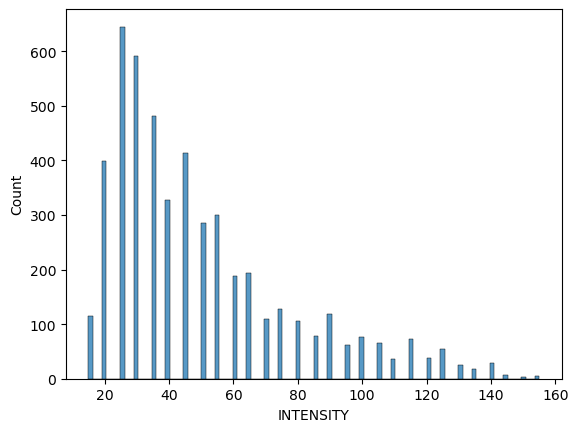

In [5]:
sns.histplot(tcir_info, x='INTENSITY', bins=100)

## Fitting distributions

(1.5015427610630756, 14.318897771306201, 23.41944310784116)


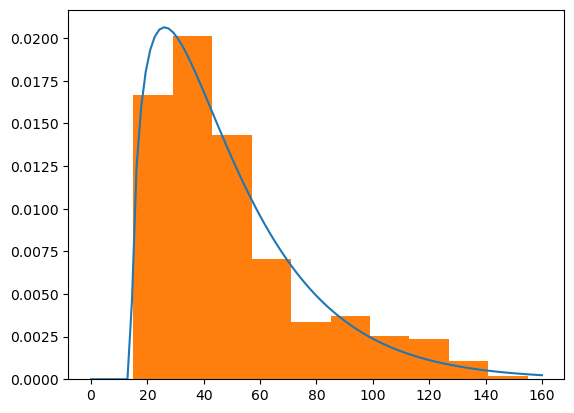

In [13]:
params = ss.gamma.fit(tcir_info['INTENSITY'])
print(params)
x = np.linspace(0, 160, 100)
plt.plot(x, ss.gamma.pdf(x, *params))
plt.hist(tcir_info['INTENSITY'], density=True)
plt.show()

(0.7137769424035233, 9.603758936236593, 31.268912745143233)


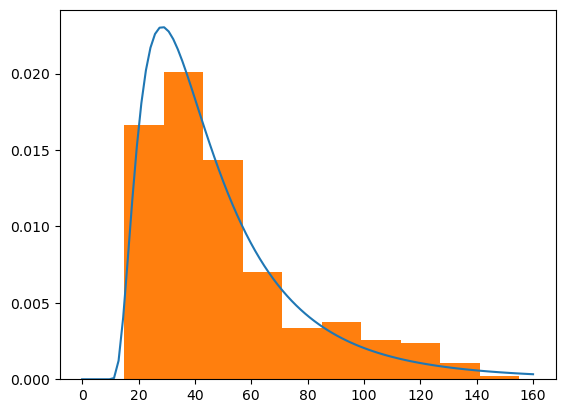

In [8]:
params = ss.lognorm.fit(tcir_info['INTENSITY'])
print(params)
x = np.linspace(0, 160, 100)
plt.plot(x, ss.lognorm.pdf(x, *params))
plt.hist(tcir_info['INTENSITY'], density=True)
plt.show()

(37.2459401878589, 19.20534642860535)


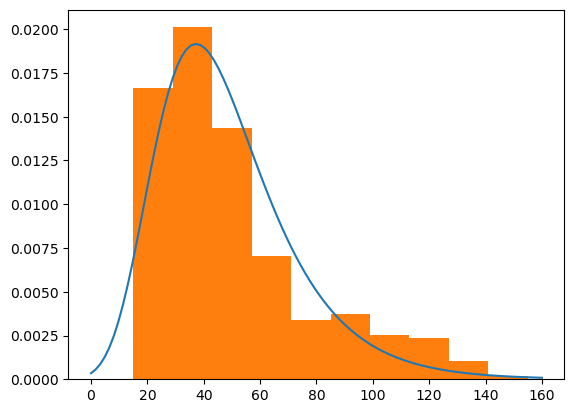

In [11]:
params = ss.gumbel_r.fit(tcir_info['INTENSITY'])
print(params)
x = np.linspace(0, 160, 100)
plt.plot(x, ss.gumbel_r.pdf(x, *params))
plt.hist(tcir_info['INTENSITY'], density=True)
plt.show()

## Temporal conditional distributions

Let's now look at the distribution of the *next* intensity, i.e. $P(Y_t|Y_{t-1})$:

In [17]:
tcir_info['NEXT_INTENSITY'] = tcir_info['INTENSITY'].shift(-1)
tcir_info['DELTA_INTENSITY'] = (tcir_info['NEXT_INTENSITY'] - tcir_info['INTENSITY']).dropna(axis='rows')
tcir_info.head(10)

,level_0,index,BASIN,SID,LON,LAT,ISO_TIME,INTENSITY,R35_4qAVG,MSLP,NEXT_INTENSITY,DELTA_INTENSITY
0,0,0,ATLN,200301L_0,-66.2,29.1,2003-04-18 00:00:00,30.0,0.0,1008.0,30.0,0.0
1,1,2,ATLN,200301L_0,-66.0,29.9,2003-04-18 06:00:00,30.0,0.0,1008.0,30.0,0.0
2,2,4,ATLN,200301L_0,-65.8,30.8,2003-04-18 12:00:00,30.0,0.0,1008.0,30.0,0.0
3,3,6,ATLN,200301L_0,-66.3,31.9,2003-04-18 18:00:00,30.0,0.0,1007.0,30.0,0.0
4,4,8,ATLN,200301L_0,-66.9,33.0,2003-04-19 00:00:00,30.0,0.0,1007.0,35.0,5.0
5,5,10,ATLN,200301L_0,-67.6,33.8,2003-04-19 06:00:00,35.0,0.0,1006.0,35.0,0.0
6,6,12,ATLN,200301L_0,-68.6,34.5,2003-04-19 12:00:00,35.0,0.0,1006.0,35.0,0.0
7,7,14,ATLN,200301L_0,-69.1,34.3,2003-04-19 18:00:00,35.0,0.0,1006.0,40.0,5.0
8,8,16,ATLN,200301L_0,-69.0,33.6,2003-04-20 00:00:00,40.0,0.0,1005.0,40.0,0.0
9,9,18,ATLN,200301L_0,-68.9,32.7,2003-04-20 06:00:00,40.0,0.0,1003.0,45.0,5.0


<Axes: xlabel='DELTA_INTENSITY', ylabel='Count'>

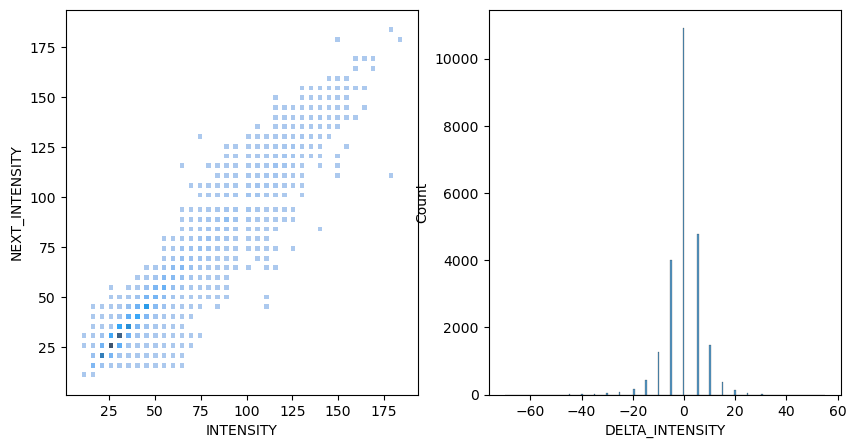

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.histplot(tcir_info, x='INTENSITY', y='NEXT_INTENSITY', ax=axes[0])
sns.histplot(tcir_info, x='DELTA_INTENSITY', ax=axes[1])

$P(Y_t | Y_{t-1})$ is close to a normal distribution.

One could wonder: is the evolution of the intensity over more than two timesteps a multivariate gaussian ?

In [33]:
vmax_evol_df = tcir_info[['SID', 'ISO_TIME', 'INTENSITY']].copy()
for i in range(1, 5):
    vmax_evol_df[f'INTENSITY_+{i}'] = vmax_evol_df['INTENSITY'].shift(-i)
vmax_evol_df = vmax_evol_df.dropna(axis='rows')
vmax_evol_df.head(10)

,SID,ISO_TIME,INTENSITY,INTENSITY_+1,INTENSITY_+2,INTENSITY_+3,INTENSITY_+4
0,200301L_0,2003-04-18 00:00:00,30.0,30.0,30.0,30.0,30.0
1,200301L_0,2003-04-18 06:00:00,30.0,30.0,30.0,30.0,35.0
2,200301L_0,2003-04-18 12:00:00,30.0,30.0,30.0,35.0,35.0
3,200301L_0,2003-04-18 18:00:00,30.0,30.0,35.0,35.0,35.0
4,200301L_0,2003-04-19 00:00:00,30.0,35.0,35.0,35.0,40.0
5,200301L_0,2003-04-19 06:00:00,35.0,35.0,35.0,40.0,40.0
6,200301L_0,2003-04-19 12:00:00,35.0,35.0,40.0,40.0,45.0
7,200301L_0,2003-04-19 18:00:00,35.0,40.0,40.0,45.0,45.0
8,200301L_0,2003-04-20 00:00:00,40.0,40.0,45.0,45.0,50.0
9,200301L_0,2003-04-20 06:00:00,40.0,45.0,45.0,50.0,50.0


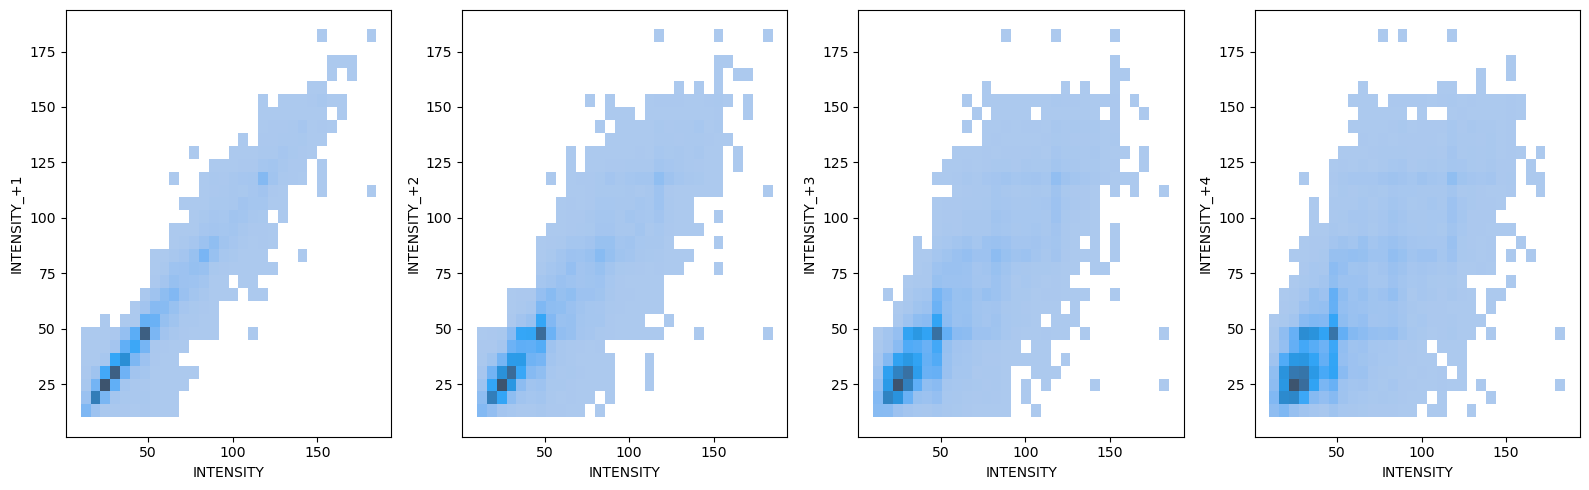

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 5), tight_layout=True)
for i in range(1, 5):
    sns.histplot(vmax_evol_df, x='INTENSITY', y=f'INTENSITY_+{i}', ax=axes[i-1], bins=30)